[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

[RF-DETR](https://blog.roboflow.com/rf-detr) is a real-time object detection model architecture developed by Roboflow. RF-DETR achieves best-in-class performance on RF100VL, an object detection benchmark designed to measure a model's ability to generalise well to different domains. In addition, by scaling resolution to 728, we achieve 60.5 mAP at 25 FPS on an NVIDIA T4 GPU, becoming the first documented real-time model to break the 60mAP barrier on the Microsoft COCO benchmark.

## Environment setup

### Configure API keys

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Mar 19 20:38:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

In [ ]:
!pip install -q git+https://github.com/roboflow/rf-detr.git@release

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

### Download example data

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

rf-detr-base.pth: 100%|██████████| 355M/355M [00:04<00:00, 80.0MiB/s]


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Loading pretrain weights


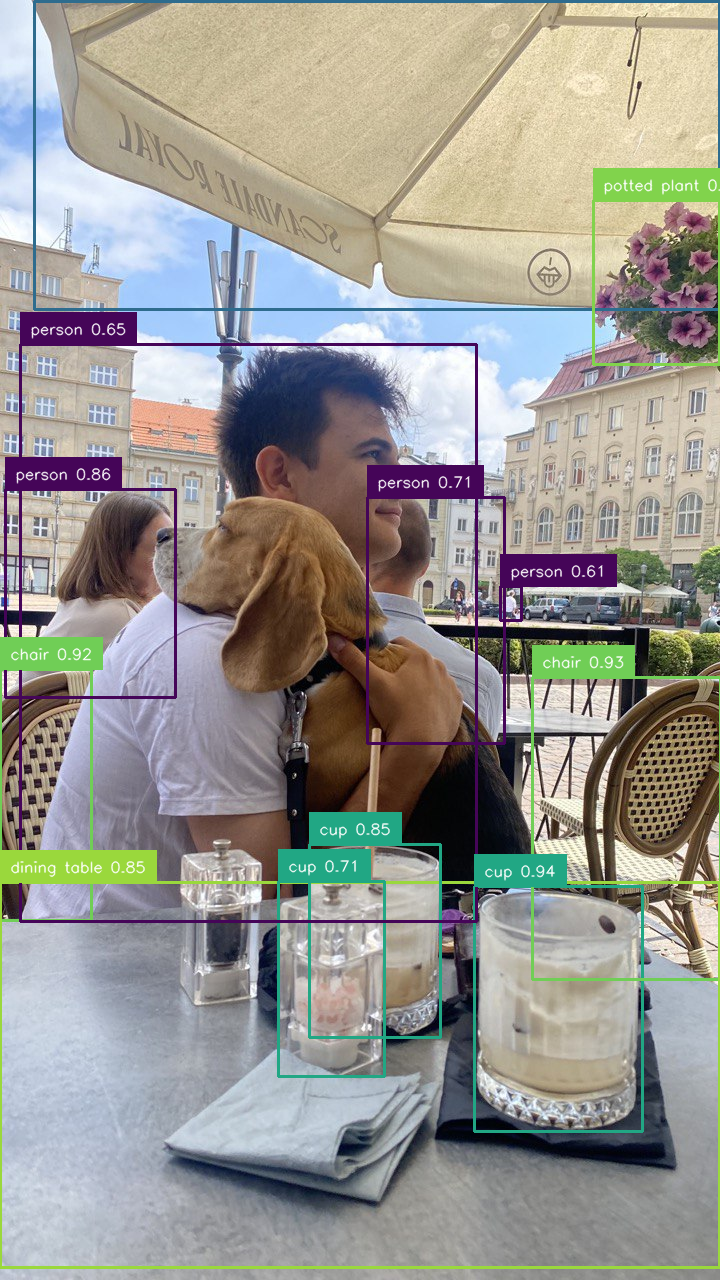

In [ ]:
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES
import supervision as sv
import numpy as np
from PIL import Image

image = Image.open("dog-2.jpeg")

model = RFDETRBase()
detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_matplotlib('viridis', len(COCO_CLASSES))
bbox_annotator = sv.BoxAnnotator(color=color)
label_annotator = sv.LabelAnnotator(color=color, smart_position=True)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image

## Download dataset from Roboflow Universe

In [ ]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/rf-100-vl/mahjong-vtacs-mexax-m4vyu-sjtd/dataset/2", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to mahjong-vtacs-mexax-m4vyu-sjtd-2 in coco:: 100%|██████████| 2143/2143 [00:04<00:00, 527.15it/s]


## Train RF-DETR on custom dataset

In [ ]:
from rfdetr import RFDETRBase

model = RFDETRBase()
history = []

def callback2(data):
    history.append(data)

model.callbacks["on_fit_epoch_end"].append(callback2)

model.train(dataset_dir=dataset.location, epochs=15, batch_size=16, grad_accum_steps=1, lr=1e-4)

Loading pretrain weights


reinitializing your detection head with 35 classes.


Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=35, grad_accum_steps=1, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=16, weight_decay=0.0001, epochs=15, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights=None, pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='vit_tiny', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[-1], freeze_encoder=False, layer_norm=False, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=8, num_queries=300, group_detr=13, two_stage=False, projector_scale='P4', lite_refpoint_refine=False, num_select=300, dec_n_points=4, decoder_norm='LN', bbox_repa

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch: [0]  [ 0/93]  eta: 0:08:59  lr: 0.000100  class_error: 92.76  loss: 5.3524 (5.3524)  loss_ce: 1.2853 (1.2853)  loss_bbox: 0.1726 (0.1726)  loss_giou: 0.3243 (0.3243)  loss_ce_0: 1.2900 (1.2900)  loss_bbox_0: 0.1693 (0.1693)  loss_giou_0: 0.3226 (0.3226)  loss_ce_1: 1.2890 (1.2890)  loss_bbox_1: 0.1734 (0.1734)  loss_giou_1: 0.3260 (0.3260)  loss_ce_unscaled: 1.2853 (1.2853)  class_error_unscaled: 92.7602 (92.7602)  loss_bbox_unscaled: 0.0345 (0.0345)  loss_giou_unscaled: 0.1621 (0.1621)  cardinality_error_unscaled: 3887.4375 (3887.4375)  loss_ce_0_unscaled: 1.2900 (1.2900)  loss_bbox_0_unscaled: 0.0339 (0.0339)  loss_giou_0_unscaled: 0.1613 (0.1613)  cardinality_error_0_unscaled: 3894.5000 (3894.5000)  loss_ce_1_unscaled: 1.2890 (1.2890)  loss_bbox_1_unscaled: 0.0347 (0.0347)  loss_giou_1_unscaled: 0.1630 (0.1630)  cardinality_error_1_unscaled: 3878.6250 (3878.6250)  loss_ce_enc_unscaled: 1.2570 (1.2570)  loss_bbox_enc_unscaled: 0.0353 (0.0353)  loss_giou_enc_unscaled: 0.1686 (0

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Test:  [ 0/27]  eta: 0:01:28  class_error: 90.48  loss: 5.1426 (5.1426)  loss_ce: 1.2344 (1.2344)  loss_bbox: 0.1603 (0.1603)  loss_giou: 0.3017 (0.3017)  loss_ce_0: 1.2344 (1.2344)  loss_bbox_0: 0.1739 (0.1739)  loss_giou_0: 0.3175 (0.3175)  loss_ce_1: 1.2500 (1.2500)  loss_bbox_1: 0.1609 (0.1609)  loss_giou_1: 0.3096 (0.3096)  loss_ce_unscaled: 1.2344 (1.2344)  class_error_unscaled: 90.4762 (90.4762)  loss_bbox_unscaled: 0.0321 (0.0321)  loss_giou_unscaled: 0.1509 (0.1509)  cardinality_error_unscaled: 292.9375 (292.9375)  loss_ce_0_unscaled: 1.2344 (1.2344)  loss_bbox_0_unscaled: 0.0348 (0.0348)  loss_giou_0_unscaled: 0.1587 (0.1587)  cardinality_error_0_unscaled: 291.7500 (291.7500)  loss_ce_1_unscaled: 1.2500 (1.2500)  loss_bbox_1_unscaled: 0.0322 (0.0322)  loss_giou_1_unscaled: 0.1548 (0.1548)  cardinality_error_1_unscaled: 292.5000 (292.5000)  loss_ce_enc_unscaled: 0.7852 (0.7852)  loss_bbox_enc_unscaled: 0.1068 (0.1068)  loss_giou_enc_unscaled: 0.4100 (0.4100)  cardinality_error

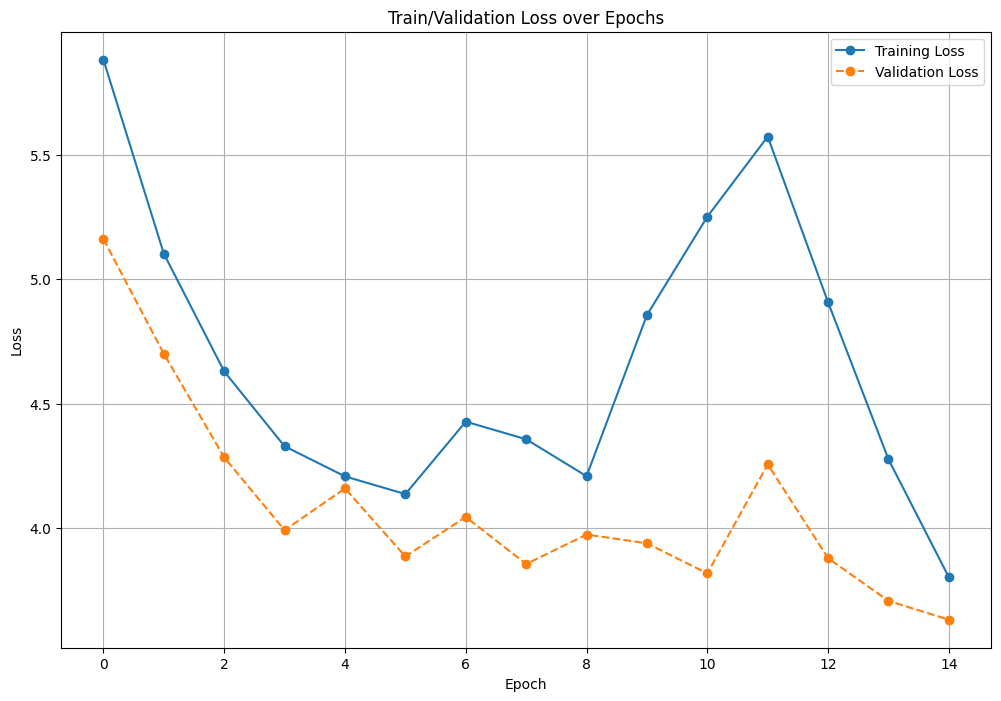

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

plt.figure(figsize=(12, 8))

plt.plot(
    df['epoch'],
    df['train_loss'],
    label='Training Loss',
    marker='o',
    linestyle='-'
)

plt.plot(
    df['epoch'],
    df['test_loss'],
    label='Validation Loss',
    marker='o',
    linestyle='--'
)

plt.title('Train/Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

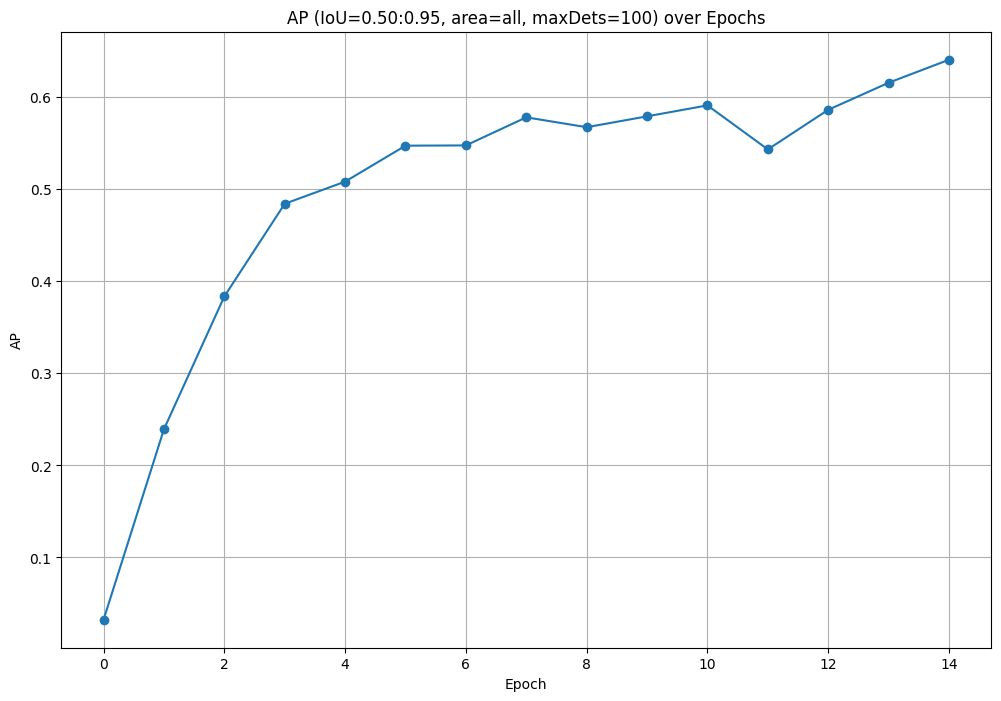

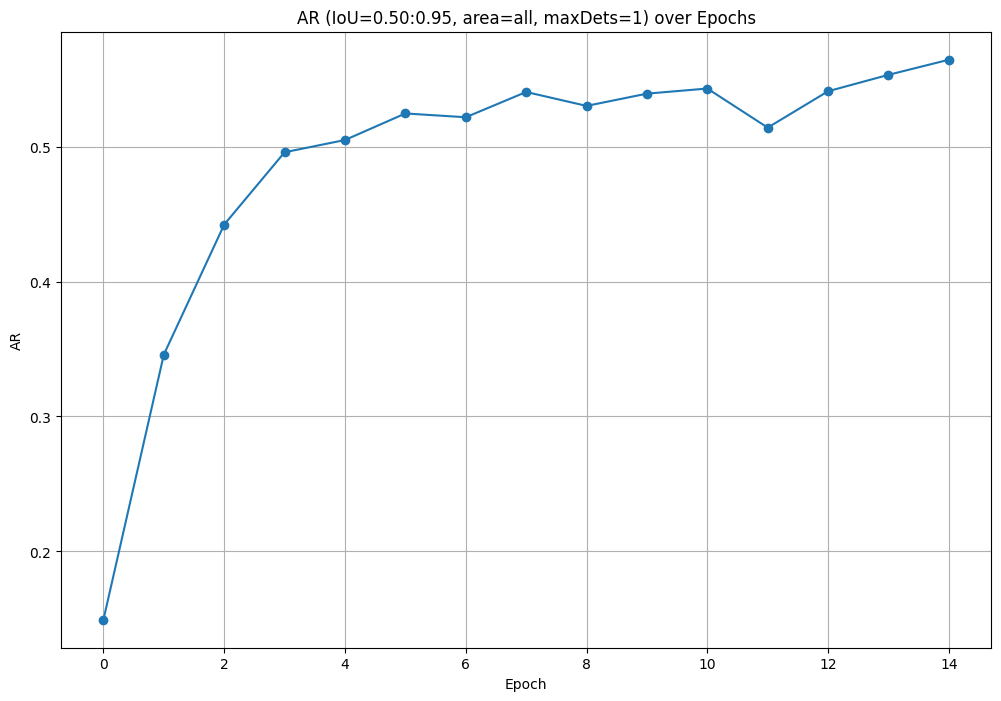

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(history)

df['avg_precision'] = df['test_coco_eval_bbox'].apply(lambda arr: arr[0])
df['avg_recall'] = df['test_coco_eval_bbox'].apply(lambda arr: arr[6])

plt.figure(figsize=(12, 8))
plt.plot(
    df['epoch'],
    df['avg_precision'],
    marker='o',
    linestyle='-'
)
plt.title('AP (IoU=0.50:0.95, area=all, maxDets=100) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AP')
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 8))
plt.plot(
    df['epoch'],
    df['avg_recall'],
    marker='o',
    linestyle='-'
)
plt.title('AR (IoU=0.50:0.95, area=all, maxDets=1) over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AR')
plt.grid(True)
plt.show()

## Evaluate fine-tuned model

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

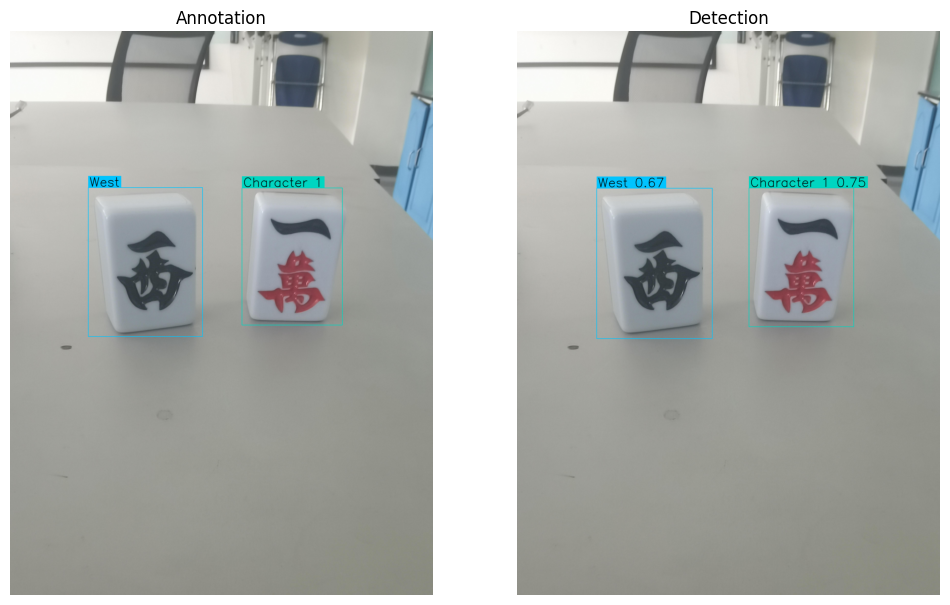

In [ ]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

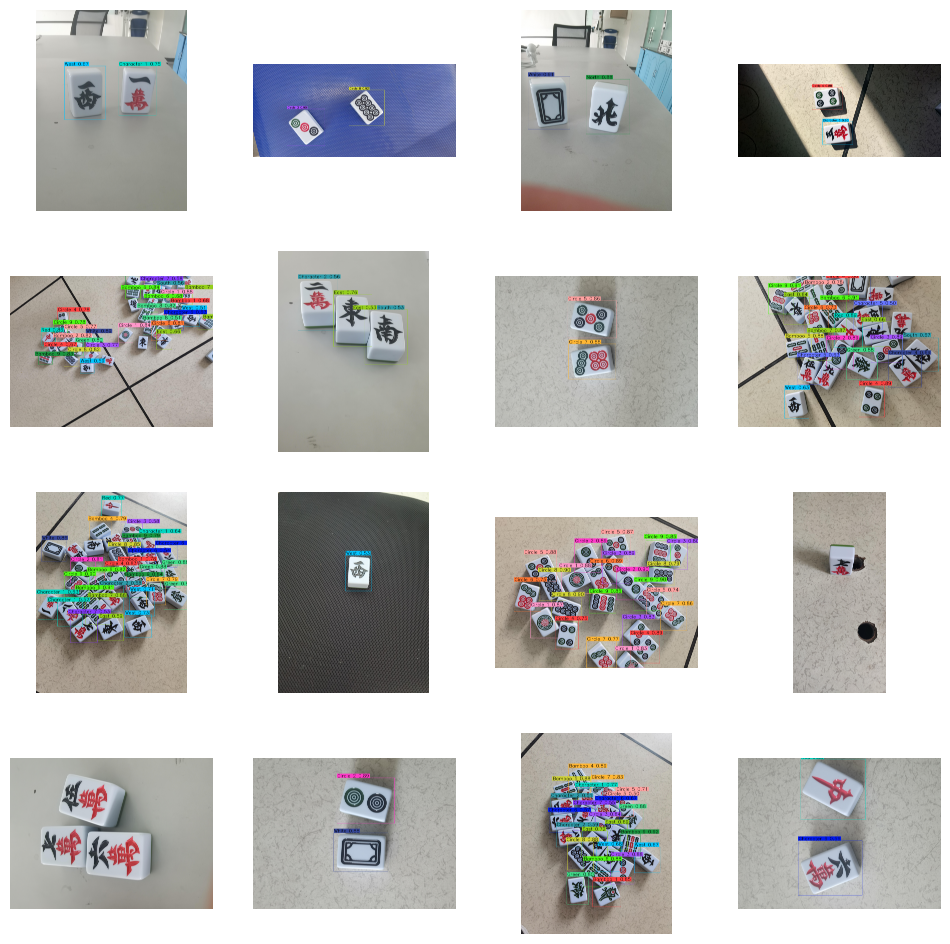

In [ ]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(16):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(4, 4))

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

100%|██████████| 214/214 [00:57<00:00,  3.70it/s]


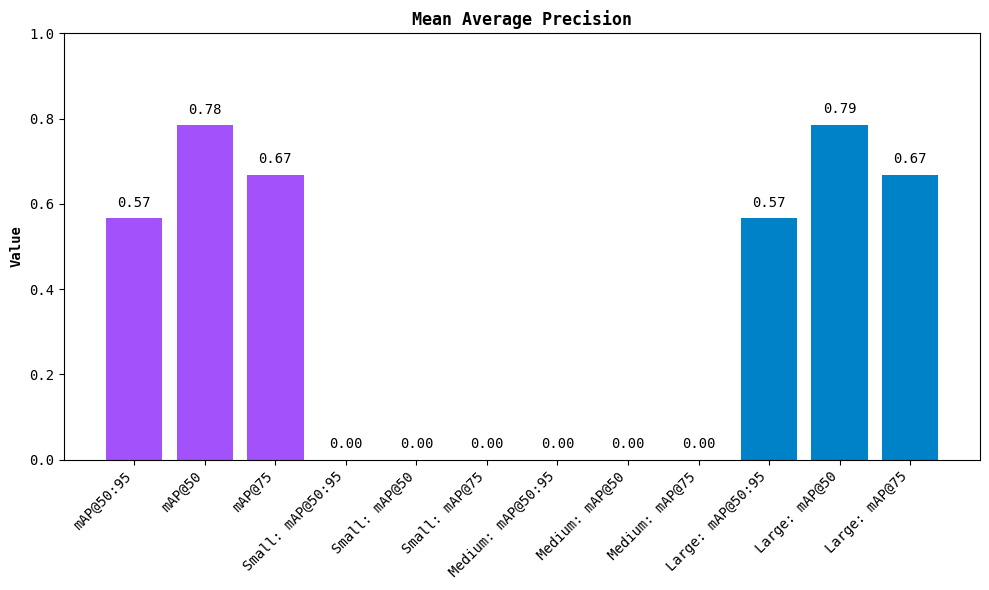

In [ ]:
map_result.plot()

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 40 notebooks that walk through how to train custom models with a range of model types, from RF-DETR to SAM 2.1.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.